In [1]:
from nilearn import plotting
from nilearn.input_data import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.ensemble import RandomForestRegressor 
import regression_common

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will

In [13]:
# Create/store/load binary image data
if not os.path.isfile('../data/binary_imgs.npy'):
  
    dataset_path = "../sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
    img_filenames = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
    img_filenames.sort()
    print('Number of subjects: %d' % len(img_filenames))
    
    img_shape = load_img(img_filenames[0]).shape
    
    mask_img = load_mni152_brain_mask()
    masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache', verbose=5)
    masker = masker.fit()
    
    imgs = masker.transform(img_filenames) # break down into slices if necessary
    imgs = imgs.astype(bool)
    np.save('../data/binary_imgs', imgs)

else:
    imgs = np.load('../data/binary_imgs.npy')
    
imgs.shape

(1401, 228453)

## Multitask analysis with 100 PC components

In [3]:
# Calculate 100 PC components
if not os.path.isfile('../data/binary_imgs_pc_100.npy'):    
    pca = PCA(n_components=100, copy=False)
    X_pc = pca.fit_transform(imgs)
    np.save('../data/binary_imgs_pc_100.npy', X_pc)
    
else:
    X_pc = np.load('../data/binary_imgs_pc_100.npy')
    
X_pc.shape

(1401, 100)

In [4]:
patient_df = pd.read_hdf('../data/patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))

### Multitask Ridge

In [5]:
def perform_multitask_ridge(X, Y):
    print('Performing Multitask Ridge regression (5-fold nested CV)')
    estimator = MultiTaskElasticNet(l1_ratio=0.001)
    alpha = np.linspace(0, 100, 51)
    my_grid={"alpha": alpha}
    return regression_common.perform_regression(X, Y, estimator, my_grid)

In [6]:
scores_mr = perform_multitask_ridge(X_pc, Y)

Performing Multitask Ridge regression (5-fold nested CV)

Fold-1: Best params: {'alpha': 54.0}

Fold-2: Best params: {'alpha': 34.0}

Fold-3: Best params: {'alpha': 32.0}

Fold-4: Best params: {'alpha': 22.0}

Fold-5: Best params: {'alpha': 40.0}


### Random Forest Regression

In [7]:
def perform_random_forest_regr(X, Y):
    print('Performing Random Forest regression (5-fold nested CV)')
    estimator = RandomForestRegressor(random_state=39)

    n_estimators = [100, 500, 1000, 2000]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [5, 10, 50, None]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [2, 4, 8]
    max_samples = [0.5, 0.7, 0.8, 0.9]
    
    my_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}
    
    return regression_common.perform_regression(X, Y, estimator, my_grid, random_search_cv=True)

In [8]:
scores_rf = perform_random_forest_regr(X_pc, Y)

Performing Random Forest regression (5-fold nested CV)

Fold-1: Best params: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.7, 'max_features': 'log2', 'max_depth': 5}

Fold-2: Best params: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.7, 'max_features': 'log2', 'max_depth': 5}

Fold-3: Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.5, 'max_features': 'sqrt', 'max_depth': 10}

Fold-4: Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.5, 'max_features': 'sqrt', 'max_depth': 10}

Fold-5: Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.5, 'max_features': 'sqrt', 'max_depth': 10}


In [10]:
# Plot results

scores_all_models = pd.DataFrame()

scores_mr.insert(0, "Model", "Multitask Ridge")
scores_rf.insert(0, "Model", "Random Forest")

scores_all_models = pd.concat([scores_mr, scores_rf], ignore_index=True)

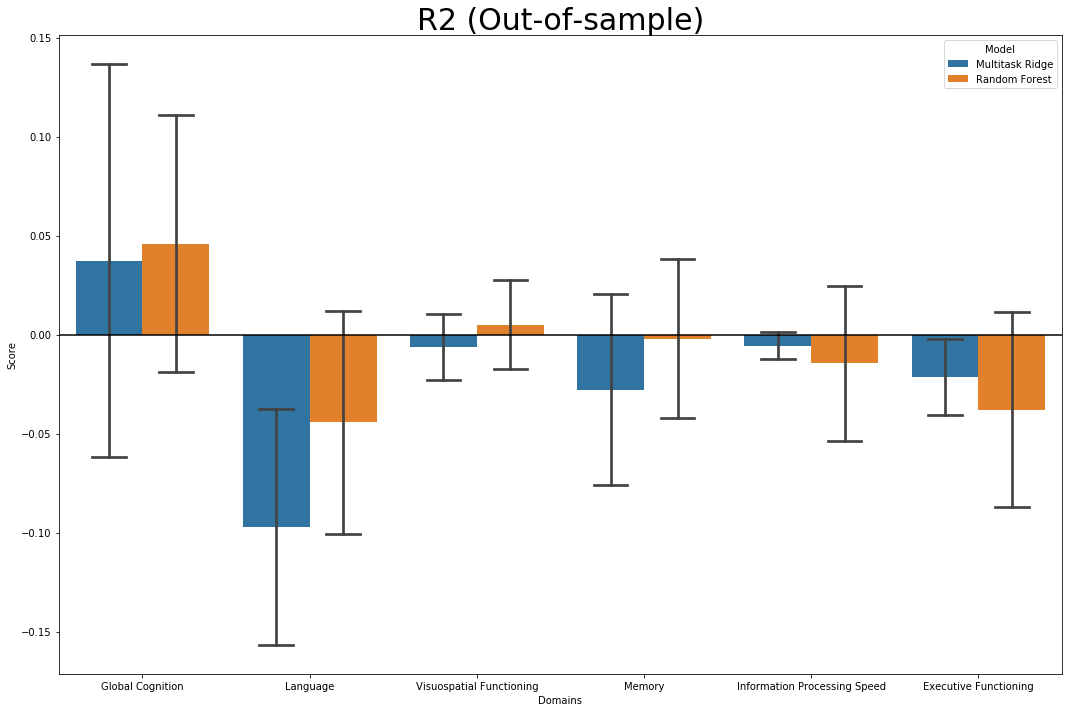

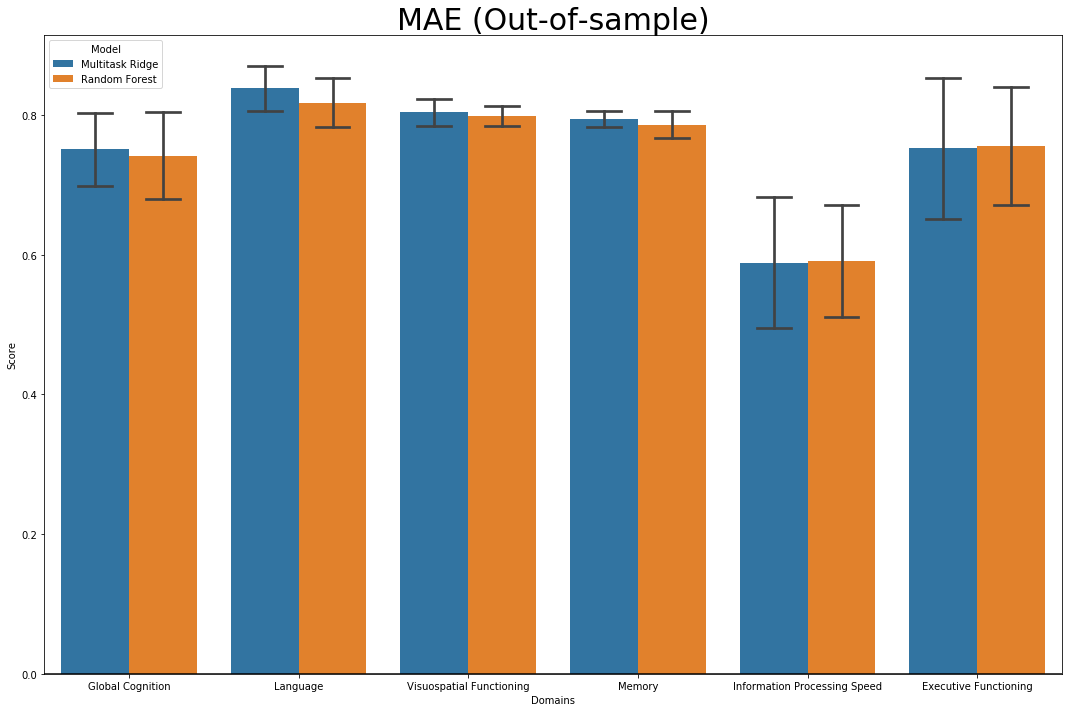

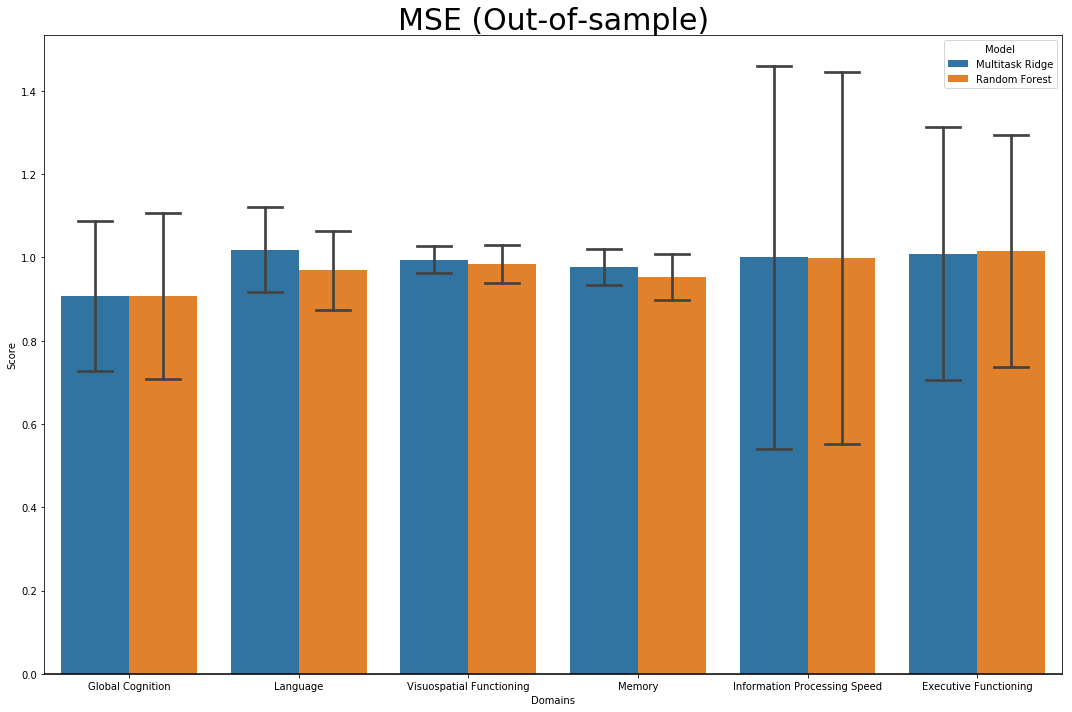

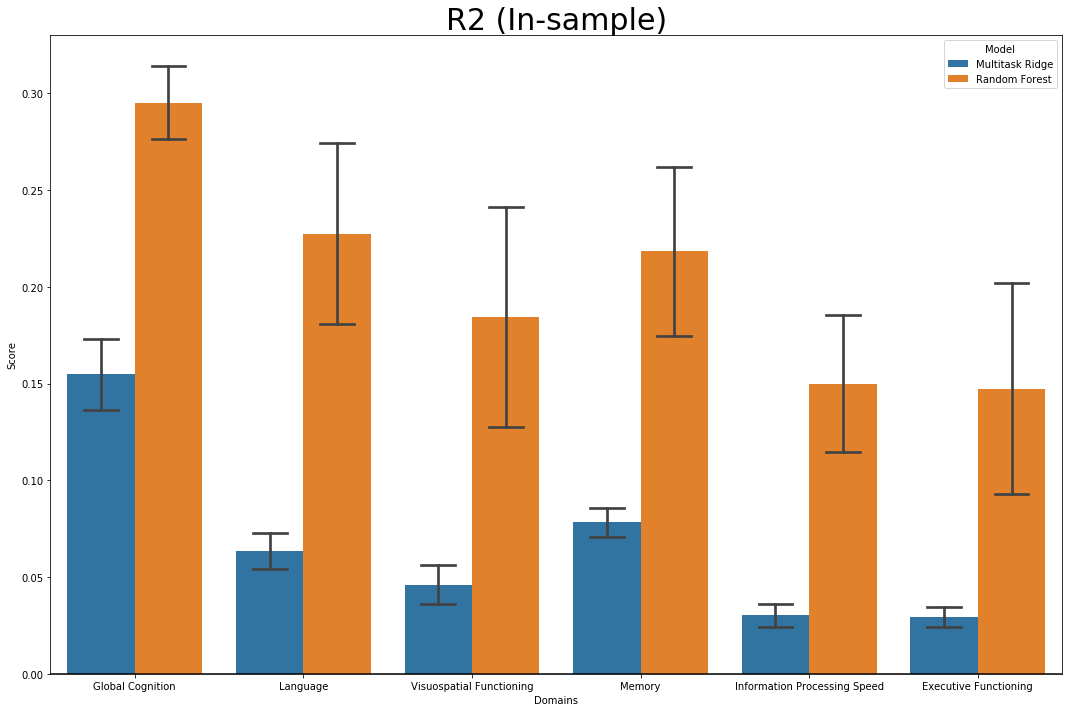

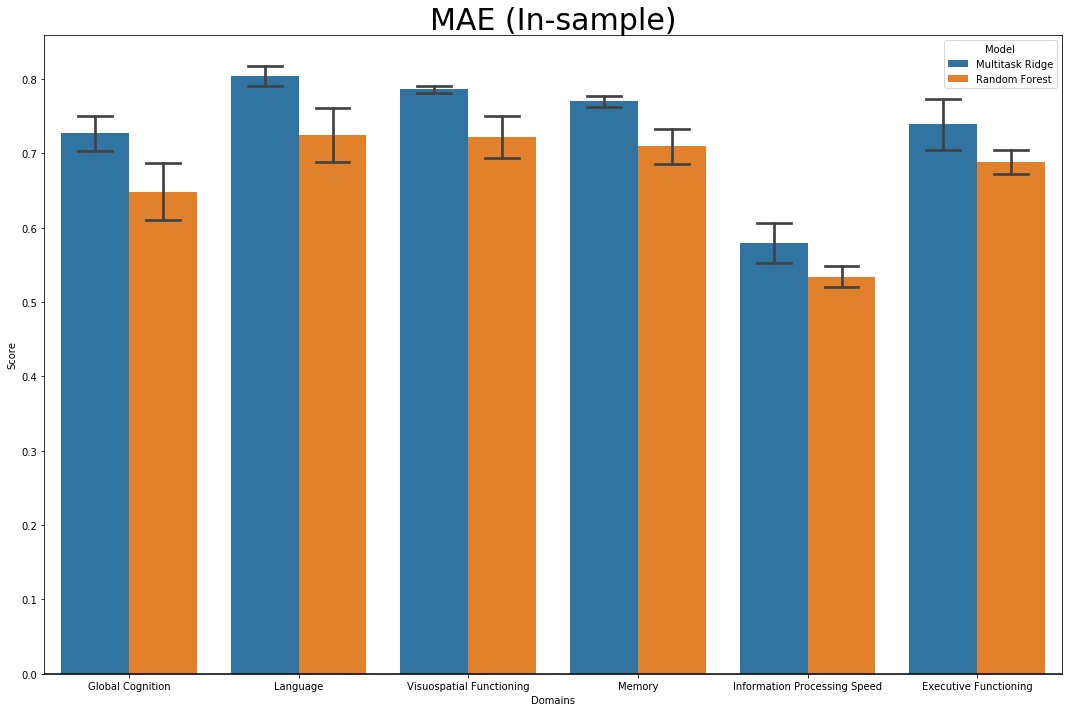

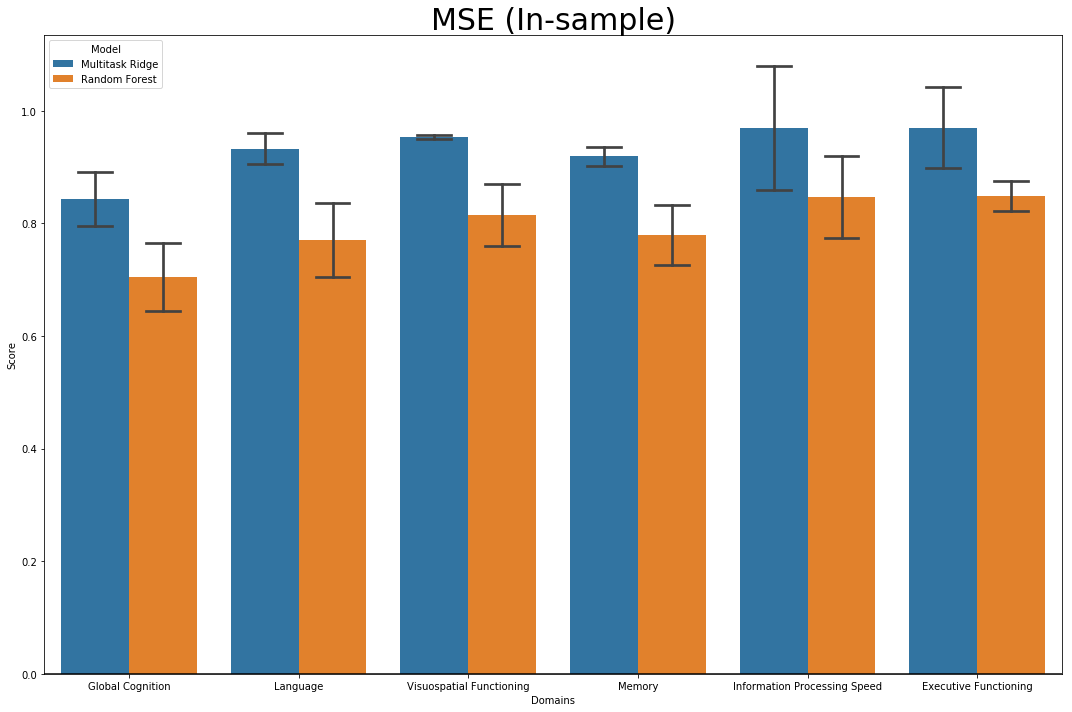

In [11]:
regression_common.plot_all_scores(scores_all_models)